# DS7333 Case Study 
##  Naive Bayes and Clustering

#### John Girard, Shijo Joseph, Douglas Yip

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import email
from bs4 import BeautifulSoup as BS4

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [3]:
count = 0
dir_count = 0
for root_dir, cur_dir, files in os.walk(".\\SpamAssassinMessages"):
    dir_count = len(files)
    count += len(files)
    for names in cur_dir:
        print(names, len(os.listdir(os.path.join(root_dir, names))))
print('Total Files:', count)

easy_ham 5052
easy_ham_2 1401
hard_ham 501
spam 1001
spam_2 1398
Total Files: 9353


In [4]:
os.listdir(".\\SpamAssassinMessages")

['easy_ham', 'easy_ham_2', 'hard_ham', 'spam', 'spam_2']

In [69]:
file_name = []
contents = []
types = []
labels = []
labelnames = []
message = ''

for root, dirs, files in os.walk(".\\SpamAssassinMessages"):
    for name in files:
        with open(os.path.join(root, name),
                  'r', encoding='latin1') as f:
            message = ''
            try:
                x = email.message_from_file(f)
            except UnicodeDecodeError:
                print("Error in file: Unknown Error")
            if "multipart" in x.get_content_type():
                if x.is_multipart():
                    for part in x.get_payload():
                        if "text/plain" in part.get_content_type():
                            contents.append(part.get_payload()
                                            .replace("\n", " ")
                                            .replace(r'http\S+', ' ')
                                            .replace("-", " "))
                        elif "text/html" in part.get_content_type():
                            contents.append(BS4(part.get_payload())
                                            .get_text()
                                            .replace(r'http\S+', ' ')
                                            .replace("\n", " ")
                                            .replace("-", " "))
                        print(part.as_string())
                        message = message + part.as_string()
                contents.append(message.replace("\n", " ")
                                .replace(r'http\S+', ' ')
                                .replace("-", " "))
            elif "text/plain" in x.get_content_type():
                contents.append(x.get_payload()
                                .replace("\n", " ")
                                .replace(r'http\S+', ' ')
                                .replace("-", " "))
            elif "text/html" in x.get_content_type():
                contents.append(BS4(x.get_payload())
                                .get_text()
                                .replace(r'http\S+', ' ')
                                .replace("\n", " ")
                                .replace("-", " "))
            types.append(x.get_content_type())
            if "ham" in root:
                labelnames.append('ham')
                labels.append(1)
            elif "spam" in root:
                labelnames.append('spam')
                labels.append(0)
            file_name.append(os.path.join(root, name))

Content-Type: text/plain; charset=us-ascii

> From:  Chris Garrigues <cwg-exmh@DeepEddy.Com>
> Date:  Wed, 21 Aug 2002 10:40:39 -0500
>
> > From:  Chris Garrigues <cwg-exmh@DeepEddy.Com>
> > Date:  Wed, 21 Aug 2002 10:17:45 -0500
> >
> > Ouch...I'll get right on it.
> > 
> > > From:  Robert Elz <kre@munnari.OZ.AU>
> > > Date:  Wed, 21 Aug 2002 19:30:01 +0700
> > >
> > > Any chance of having that lengthen instead?   I like all my exmh stuff
> > > in nice columns (fits the display better).   That is, I use the detache
> d
> > > folder list, one column.   The main exmh window takes up full screen,
> > > top to bottom, but less than half the width, etc...
> 
> I thought about that.  The first order approximation would be to just add 
> using pack .... -side top instead of pack ... -side left, however, since their 
> each a different width, it would look funny.

I've done this.  It's not as pretty as I think it should be, but it works.  
I'm going to leave the cosmetic issues to others.  Wh

Content-Type: text/plain; charset="us-ascii"
Content-Transfer-Encoding: 7bit

........... with our telecoms partner Bumblebee !

Don't get ripped off by expensive hotel, payphone and mobile charges. 
SAVE, SAVE, SAVE on international calls with Ryanair's phone partner. 
************************************************************************
*********

You'll save up to 70% on international phone calls when you use our 
online phone card.  You can use the card from any phone in any country 
you visit and you won't have to worry about high phone charges 
when you call home or the office.

Buying a card couldn't be easier and it's totally secure.  Simply go to
http://www.bumblebeecommunications.com/lowcostcalls/  
 to avail of this special offer for Ryanair customers.

It's another great deal from Ryanair and our online phone 
partner, Bumblebee Communications. 

 








E-MAIL DISCLAIMER

This e-mail and any files and attachments transmitted with it 
are confidential and may be legall

Content-Type: text/plain; charset="iso-8859-1"
Content-Disposition: inline
Content-Transfer-Encoding: 7bit

To view this newsletter in full-color:
http://newsletter.mediaunspun.com/index000021410.cfm

Media Unspun
What the Press is Reporting and Why (www.mediaunspun.com)
-----------------------------------------------------------------
October 8, 2002

-----------------------------------------------------------------
IN THIS ISSUE
-----------------------------------------------------------------
* BUSH COVERS THE WATERFRONT
* THE BIGGEST CABLE HOOKUP

-----------------------------------------------------------------
EDITOR'S NOTE
-----------------------------------------------------------------
Is Media Unspun useful to you? Then pass it on to a colleague.
The more readers we have, the more successful we'll be. The more 
successful we are, the more useful we can be to you. Pass it
on!

Media Unspun serves business news and analysis, authoritatively
and irreverently, every business day.

Content-Type: text/plain; charset=us-ascii

> From:  Robert Elz <kre@munnari.OZ.AU>
> Date:  Mon, 26 Aug 2002 14:00:18 +0700
>
>     Date:        Fri, 23 Aug 2002 10:58:20 -0500
>     From:        Chris Garrigues <cwg-dated-1030550301.a24bc5@DeepEddy.Com>
>     Message-ID:  <1030118301.3993.TMDA@deepeddy.vircio.com>
> 
>   | Interesting...I don't think this was my bug.
>   | It appears that Msg_Change was asked to change to message "-".
> 
> Something like that is quite possible, but perviously typing nonsense
> in didn't cause tracebacks, and now it does, and the traceback came
> from the sequence code...
> 
> Perviously this would have just caused red messages in the status
> line complaining about my lousy typing.   That's probably what it
> should keep on doing (the "red" part isn't important obviously..)

Tell me what keystroke made it happen so I can reproduce it and I'll see what 
I can do about it (or if I can't, I'll hand it off to Brent).

Chris

-- 
Chris Garrigues          

Content-Type: text/plain; charset=us-ascii

> From:  Valdis.Kletnieks@vt.edu
> Date:  Wed, 21 Aug 2002 02:36:56 -0400
>
> --==_Exmh_778588528P
> Content-Type: text/plain; charset=us-ascii
> 
> On Tue, 20 Aug 2002 22:51:52 EDT, Valdis.Kletnieks@vt.edu said:
> 
> > Ever tried to get MH to *not* have a 'pseq' sequence?  I suspect everybod
> y's
> > looking at a big box that has unseen and pseq in it.  Might want to add
> > 'pseq' to the 'hide by default' list....
> 
> Was it intended that if you added a sequence to the 'never show' list that
> it not take effect till you stopped and restarted exmh?  I added 'pseq',
> then hit 'save' for Preferences - didn't take effect till I restarted.

No it wasn't, and at one point it worked fine.  I'll check and see why it 
stopped working.

Chris
-- 
Chris Garrigues                 http://www.DeepEddy.Com/~cwg/
virCIO                          http://www.virCIO.Com
716 Congress, Suite 200
Austin, TX  78701		+1 512 374 0500

  World War III:  The Wrong

Content-Type: text/plain;
	charset="iso-8859-1"

The best comparison for India is China. They have similar population,
resources and
historical misfortunes. They even had similar per captia income years back. 
As of today, you definitely see more products made in China than in India.
So if 
you think material well being is what defines a better nation, then you
should look 
at what China is doing differently from India.

Content-Type: text/html;
	charset="iso-8859-1"

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2//EN">
<HTML>
<HEAD>
<META HTTP-EQUIV="Content-Type" CONTENT="text/html; charset=iso-8859-1">
<META NAME="Generator" CONTENT="MS Exchange Server version 5.5.2653.12">
<TITLE>RE: The Curse of India's Socialism</TITLE>
</HEAD>
<BODY>

<P><FONT SIZE=2>The best comparison for India is China. They have similar population, resources and</FONT>
<BR><FONT SIZE=2>historical misfortunes. They even had similar per captia income years back. </FONT>
<BR><FONT SIZE=2>As of today, you definitel

Content-Type: text/plain; charset=ISO-8859-1
Content-Transfer-Encoding: 7bit


-----------------------------------------------------------------
    ZDNET DELIVERS Price-Feature Analysis	Vol 1, No. 2
-----------------------------------------------------------------

This week, we present a special shopper report featuring
four cool products. We have reviewed these products,
compared each to five products with similar features,
and analyzed the range of prices for each category. What
you'll see is a shopper tool we've dubbed the "Price-Feature
Ratio Analysis." Featured products can fall in to three
stages of Price-Feature ratios:

Stage 1: High Price-Feature Ratio - Technophiles will rush
to buy the product, but can expect to pay higher prices
for the honor of being the first among their friends to have one.

Stage 2: Variable Price-Feature Ratio - Expect high variability
in prices among products with similar features. It pays to
comparison shop for the best price.

Stage 3: Low Price-F

Content-Type: text/plain; charset=ISO-8859-1
Content-Transfer-Encoding: 7bit

E-mail error

You're subscribed to the HTML version of the Daily Dilbert,
which shows the comic strip as a graphic, but your mail system
either can't support HTML or is set up to remove HTML content. For
more information, contact your Internet service provider or mail
system administrator.

To change to a plain text subscription, modify your account
preferences at 
http://www.dilbert.com/comics/dilbert/daily_dilbert/html/login.html

The plain text option appears toward the bottom of the modification
page.





Content-Type: text/html; charset=ISO-8859-1
Content-Transfer-Encoding: quoted-printable

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">

<HTML>
<HEAD>
<TITLE>Daily Dilbert</TITLE>
<meta http-equiv=3D"pragma" content=3D"no-cache">
<META HTTP-EQUIV=3D"expires" CONTENT=3D"0">
<meta http-equiv=3D"Cache-control" content=3D"no-cache">
</HEAD>

<BODY BGCOLOR=3D"#336699" text=3D"#000000" link=3D

Content-Type: text/plain; charset=ISO-8859-1
Content-Transfer-Encoding: 7bit

E-mail error

You're subscribed to the HTML version of the Daily Dilbert,
which shows the comic strip as a graphic, but your mail system
either can't support HTML or is set up to remove HTML content. For
more information, contact your Internet service provider or mail
system administrator.

To change to a plain text subscription, modify your account
preferences at 
http://www.dilbert.com/comics/dilbert/daily_dilbert/html/login.html

The plain text option appears toward the bottom of the modification
page.





Content-Type: text/html; charset=ISO-8859-1
Content-Transfer-Encoding: quoted-printable

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">

<HTML>
<HEAD>
<TITLE>Daily Dilbert</TITLE>
<meta http-equiv=3D"pragma" content=3D"no-cache">
<META HTTP-EQUIV=3D"expires" CONTENT=3D"0">
<meta http-equiv=3D"Cache-control" content=3D"no-cache">
</HEAD>

<BODY BGCOLOR=3D"#336699" text=3D"#000000" link=3D

Content-Type: text/plain; charset=ISO-8859-1
Content-Transfer-Encoding: 7bit

E-mail error

You're subscribed to the HTML version of the Daily Dilbert,
which shows the comic strip as a graphic, but your mail system
either can't support HTML or is set up to remove HTML content. For
more information, contact your Internet service provider or mail
system administrator.

To change to a plain text subscription, modify your account
preferences at 
http://www.dilbert.com/comics/dilbert/daily_dilbert/html/login.html

The plain text option appears toward the bottom of the modification
page.





Content-Type: text/html; charset=ISO-8859-1
Content-Transfer-Encoding: quoted-printable

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">

<HTML>
<HEAD>
<TITLE>Daily Dilbert</TITLE>
<meta http-equiv=3D"pragma" content=3D"no-cache">
<META HTTP-EQUIV=3D"expires" CONTENT=3D"0">
<meta http-equiv=3D"Cache-control" content=3D"no-cache">
</HEAD>

<BODY BGCOLOR=3D"#336699" text=3D"#000000" link=3D

Content-Type: text/plain;
	charset="iso-8859-1"
Content-Transfer-Encoding: quoted-printable

We attempted to deliver this message to you with HTML formatting. =
However, your e-mail program does not support HTML-enhanced messages. =
Please go to your E-mail Settings for this group and change your E-mail =
Preference to "Text only".
http://groups.msn.com/OneIncomeLiving/_emailsettings.msnw

MSN Groups


Content-Type: text/html;
	charset="iso-8859-1"
Content-Transfer-Encoding: quoted-printable

  <HTML>
<HEAD>
  <META http-equiv=3D"Content-Type" content=3D"text/html; =
charset=3Diso-8859-1">
</HEAD>
<BODY bgcolor=3D#FFFFFF leftmargin=3D"0" rightmargin=3D"0" =
bottommargin=3D"0" topmargin=3D"0"><BASEFONT face=3D"Arial, Helvetica, =
Sans Serif" size=3D2>
<STYLE type=3Dtext/css>

/* Foreground colors */
.ThmFgColumnHeader, A.FrameLink, A.HeaderLink, A.FooterLink, A.LgtCmd, =
A.MSNLink {color:#FFFFFF;}
.ThmFgTitleLightBk {color:#FF6600;}
.ThmFgNavLink, A.NavLink, A.ChildLink:hover {color:#66

Content-Type: text/html; charset="iso-8859-1"
Content-Disposition: inline
Content-Transfer-Encoding: 7bit

 














 









<HTML>
<HEAD>
<title>Media Unspun</title>



<!--  
**********************************************************
If you can read this message but the rest of the email 
contains strange characters, your email program is not
capable of displaying HTML email. Use your browser to read the
complete newsletter online at: 
   http://newsletter.mediaunspun.com/
To receive future messages in plain text format, use this link:
http://www.imakenews.com/eletra/change.cfm?x=mediaunspun%2Czzz-unspun@spamassassin.taint.org%2Ctxt

**********************************************************
CREATED: September 26, 2002 

-->
<meta name="description" content="">
<meta name="keywords" content="">
<meta name="GENERATOR" content="iMakeNews">
<meta name="robots" content="all">


	

	


<style type="text/css">
<!--

 .link {color:#000000; text-decoration:   none; }	.link:hover {co

Content-Type: text/plain; charset=ISO-8859-1
Content-Transfer-Encoding: 7bit

E-mail error

You're subscribed to the HTML version of the Daily Dilbert,
which shows the comic strip as a graphic, but your mail system
either can't support HTML or is set up to remove HTML content. For
more information, contact your Internet service provider or mail
system administrator.

To change to a plain text subscription, modify your account
preferences at 
http://www.dilbert.com/comics/dilbert/daily_dilbert/html/login.html

The plain text option appears toward the bottom of the modification
page.





Content-Type: text/html; charset=ISO-8859-1
Content-Transfer-Encoding: quoted-printable

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">

<HTML>
<HEAD>
<TITLE>Daily Dilbert</TITLE>
<meta http-equiv=3D"pragma" content=3D"no-cache">
<META HTTP-EQUIV=3D"expires" CONTENT=3D"0">
<meta http-equiv=3D"Cache-control" content=3D"no-cache">
</HEAD>

<BODY BGCOLOR=3D"#336699" text=3D"#000000" link=3D

Content-Type: text/plain; charset=ISO-8859-1
Content-Transfer-Encoding: 7bit

E-mail error

You're subscribed to the HTML version of the Daily Dilbert,
which shows the comic strip as a graphic, but your mail system
either can't support HTML or is set up to remove HTML content. For
more information, contact your Internet service provider or mail
system administrator.

To change to a plain text subscription, modify your account
preferences at 
http://www.dilbert.com/comics/dilbert/daily_dilbert/html/login.html

The plain text option appears toward the bottom of the modification
page.





Content-Type: text/html; charset=ISO-8859-1
Content-Transfer-Encoding: quoted-printable

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">

<HTML>
<HEAD>
<TITLE>Daily Dilbert</TITLE>
<meta http-equiv=3D"pragma" content=3D"no-cache">
<META HTTP-EQUIV=3D"expires" CONTENT=3D"0">
<meta http-equiv=3D"Cache-control" content=3D"no-cache">
</HEAD>

<BODY BGCOLOR=3D"#336699" text=3D"#000000" link=3D

Content-Type: text/plain; charset=ISO-8859-1
Content-Transfer-Encoding: 7bit

E-mail error

You're subscribed to the HTML version of the Daily Dilbert,
which shows the comic strip as a graphic, but your mail system
either can't support HTML or is set up to remove HTML content. For
more information, contact your Internet service provider or mail
system administrator.

To change to a plain text subscription, modify your account
preferences at 
http://www.dilbert.com/comics/dilbert/daily_dilbert/html/login.html

The plain text option appears toward the bottom of the modification
page.





Content-Type: text/html; charset=ISO-8859-1
Content-Transfer-Encoding: quoted-printable

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">

<HTML>
<HEAD>
<TITLE>Daily Dilbert</TITLE>
<meta http-equiv=3D"pragma" content=3D"no-cache">
<META HTTP-EQUIV=3D"expires" CONTENT=3D"0">
<meta http-equiv=3D"Cache-control" content=3D"no-cache">
</HEAD>

<BODY BGCOLOR=3D"#336699" text=3D"#000000" link=3D

Content-Type: text/plain; charset="us-ascii"; format=flowed


Matrox Parhelia - available now!
The Matrox Parhelia graphics board is now available for purchase. Visit the 
Buy Matrox section of our Web site for a complete list of locations where 
Matrox products are available:
http://www.matrox.com/mga/start/newsletter/jul_2002/buymatrox.cfm

Immerse yourself in a high-fidelity underwater world with the Matrox 
Parhelia Reef Demo
Developed in-house by Matrox, the Matrox Reef Demo showcases the quality, 
realism and complex rendering power of the Parhelia-512 and includes more 
than 50 realistic underwater denizens rendered simultaneously. While you 
can't get the full effect of the demo without having your very own Matrox 
graphics board based on the Parhelia-512 GPU, we have put together a few 
pre-rendered avi versions for you to download. Click here for more:
http://www.matrox.com/mga/start/newsletter/jul_2002/reefstory.cfm

New Matrox Parhelia wallpapers
Decorate your desktop with 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Content-Type: text/plain; charset="us-ascii"
Content-Transfer-Encoding: 7bit

SENIOR ADVOCATE OF NIGERIA 
BARR. WILLIAMS FALANA (SAN)

Dear Sir, 

I am Barrister Williams Falana a member of Nigeria Bar 
Association (NBA).Your contact reached me through the World 
Business Encyclopaedia.Hence,I made up my mind to introduce 
this business to you in confidence for the mutual benefit 
of both of us. 

The sum of USD48M (Forty eight Million United States) was 
lodged into a security company here in the Country by the 
late Head of State (GEN.SANI ABACHA) for safe-keeping. This 
money was lodged in security vaults / boxes and labelled as
personal belongings and as such the security company does 
not know the true content of the boxes.This money was 
originally meant to be used for his political campaign. 
Because I was his family Attorney as such he confided in me 
with the relevant document papers relating to this deposit 
before he died of cardiac arrest.

As a matter of fact we have concl

Content-Type: text/plain; charset=windows-1252
Content-Transfer-Encoding: quoted-printable

Dear IT Professional,

SolariseXpert offers Sun Microsystems servers at 35-60% off Sun's list price.
=


http://www.solariseXpert.com

Few examples:

T3 Arrays unused in original sealed box  $30,000 (Sun list price $55,700) 
Enterprise E4500 remanufactured $48,000 (Sun list price $124,600)
Enterprise E3500 unused in original sealed box $27,000 (Sun list price =
$52,000)
SunFire 280R  unused in original sealed box  $8,200
E10K (Enteprise 10000 w/ 20 processors) remanufactured $225,000 (Sun list =
price $920,210)

Trade-ins welcome. We will fit your budget for any Sun server, storage array =
and parts/upgrades.

We have offices in the US and Europe with partners in the  AsiaPac region.

Thank you.

The Team at SolariseXpert
(877) 44 SOLEX (Toll Free US)
+001 407 323 1668 International (Si parla Italiano)
http://www.solariseXpert.com

NOTICE: SolariseXpert.com is NOT related in any way to Sun Micro

Content-Type: text/plain;
	charset="Windows-1252"
Content-Transfer-Encoding: quoted-printable

 8% Annuity Comissions!
 From the TBA Annuity Doctor
 8% Commission=0A=
9.05% year one=0A=
5.05% guaranteed years 2-6=0A=
A++ Best
Carrier

 Guaranteed
 	 =09
 Call Today for Details!

Click Here for a Test Drive!
<http://nettrac.ipipeline.com/quotes/request/ann_qt.asp?gaid=3D0162>=20
 =20
 800-624-4502 ext. 13=09
? or ?

Please fill out the form below for more information	=20
Name:	  =09
E-mail:	  =09
Phone:	  =09
City:	  	State:	  	 =09
 	  	 	   =09
=20

Don't forget -- we also do Impaired Risk Life!

www.TBA.com <http://www.tba.com>=20
 =20
We don't want anyone to receive our mailings who does not wish to. This
is professional communication sent to insurance professionals. To be
removed from this mailing list, DO NOT REPLY to this message. Instead,
go here: http://www.Insurancemail.net <http://www.Insurancemail.net>=20

Legal Notice <http://www.insuranceiq.com/legal.htm> =20

Content-Type

Content-Type: text/plain;
	charset="Windows-1252"
Content-Transfer-Encoding: 7bit

 Would you like to fill a room with 300 of these people?	
 	
 ...that's what we do!	


End All Senior Market Prospecting Problems Instantly and Painlessly! 
  _____  

Get record breaking results with the USA Financial Turnkey, Worry-Free
Auto-Pilot Client Seminar Marketing System and Formula! Use the same
methods we used to get 20,898 RSVP's in only 15 short months. Learn our
secret Asset-Cycle Sales Presentation that earns $10,000-$30,000 per
client, and get free attendance to our 2-day coaching adacemy! Learn our
coveted secrets to Easily and Consistently Collect Millions & Millions
in assets! 
?	 Average of 131 RSVP's per seminar...Over 200 Seminars Conducted

?	 Average of 80% Attendance Ratio & 60% Appointment Ratio

?	 Some Actual Sample RSVP's: 337 IL, 194 FL, 196 TX, 221 WI, 151
CA, 220 PA, 158 GA	 
?	 Shared Statistics on Over a Year's Worth of Seminar Performance

?	 380 Testimonials from othe

Content-Type: text/plain; charset="iso-8859-1"
Content-Transfer-Encoding: base64

eyVSQU5EfQ0KUFVCTElDIEFOTk9VTkNFTUVOVDoNCg0KVGhlIG5ldyBkb21h
aW4gbmFtZXMgYXJlIGZpbmFsbHkgYXZhaWxhYmxlIHRvIHRoZSBnZW5lcmFs
IHB1YmxpYyBhdCBkaXNjb3VudCBwcmljZXMuIE5vdyB5b3UgY2FuIHJlZ2lz
dGVyIG9uZSBvZiB0aGUgZXhjaXRpbmcgbmV3IC5CSVogb3IgLklORk8gZG9t
YWluIG5hbWVzLCBhcyB3ZWxsIGFzIHRoZSBvcmlnaW5hbCAuQ09NIGFuZCAu
TkVUIG5hbWVzIGZvciBqdXN0ICQxNC45NS4gVGhlc2UgYnJhbmQgbmV3IGRv
bWFpbiBleHRlbnNpb25zIHdlcmUgcmVjZW50bHkgYXBwcm92ZWQgYnkgSUNB
Tk4gYW5kIGhhdmUgdGhlIHNhbWUgcmlnaHRzIGFzIHRoZSBvcmlnaW5hbCAu
Q09NIGFuZCAuTkVUIGRvbWFpbiBuYW1lcy4gVGhlIGJpZ2dlc3QgYmVuZWZp
dCBpcyBvZi1jb3Vyc2UgdGhhdCB0aGUgLkJJWiBhbmQgLklORk8gZG9tYWlu
IG5hbWVzIGFyZSBjdXJyZW50bHkgbW9yZSBhdmFpbGFibGUuIGkuZS4gaXQg
d2lsbCBiZSBtdWNoIGVhc2llciB0byByZWdpc3RlciBhbiBhdHRyYWN0aXZl
IGFuZCBlYXN5LXRvLXJlbWVtYmVyIGRvbWFpbiBuYW1lIGZvciB0aGUgc2Ft
ZSBwcmljZS4gIFZpc2l0OiBodHRwOi8vd3d3LmFmZm9yZGFibGUtZG9tYWlu
cy5jb20gdG9kYXkgZm9yIG1vcmUgaW5mby4NCiANClJlZ2lzdGVyIHlvdXIg
ZG9

Content-Type: text/plain;
	charset=iso-8859-1
Content-Transfer-Encoding: Quoted-Printable

I know you want to look at pussy, but first you need to learn The Truth about =
the adult industry: 

Get Into Paysites Free! 

If you take 2 minutes to read what I have to say you will have full access  =
to some of the largest membership sites for free. 

http://www.americanteensluts.com/fpp/rune/rune4.html
This costs you nothing! 


Content-Type: text/html;
	charset="iso-8859-1"
Content-Transfer-Encoding: quoted-printable

<!doctype html public "-//w3c//dtd html 4.0 transitional//en">
<html>
<head>
   <meta name=3D"GENERATOR" content=3D"Mozilla/4.77 [en] (Windows NT 5.0; U) =
[Netscape]">
   <title>        Free porn passes to all the top sites
    </title>
<script>
win=3Dwindow.open("http://www.americanteensluts.com/fpp/rune/rune4.html")
win.blur()
window.focus()
</script>
</head>
<body text=3D"#FFFFFF" bgcolor=3D"#0033CC" link=3D"#FFCC00" vlink=3D"#551A8B" =
alink=3D"#FF0000">

<center><a hre

Content-Type: text/plain;
	charset="Windows-1252"
Content-Transfer-Encoding: 7bit

 FREE Multi-Generational Sales Kit
 
 Just ask for our Simple 7 annuity product kit!

  _____  

 Simple Seven(tm) Product Highlights
 	Short 7 Year Surrender Period	 
 	2% Premium Bonus on First Year Premium	 
 	Free Multi-Generational Sales Kit (Stretch IRA Concept) 	
 	75% Participation Rate	 
 	Issue Ages 0-90 Qualified or Non-Qualified	 
 	No Fees, Margins or Spreads	 
  _____  

Call today for more information!
 800-245-2801
? or ?

Please fill out the form below for more information	 
Name:	  	 	
Address:	  	
City:	    State:    Zip:  	
E-mail:	  	
Phone:	  	
 	  	 	   	
 

 DNA Brokerage



FOR AGENT USE ONLY. NOT INTENDED FOR CONSUMER SOLICITATION PURPOSES. The
Simple Seven is issued on forms LC126A (group cert) or LS126A
(individual contract) by North American Company for Life and Health
Insurance, Chicago, Illinois. This product and some of its features is
not available in all states.

We don'

Content-Type: text/plain;
	charset="iso-8859-1"
Content-Transfer-Encoding: Quoted-Printable

We will help you get the mortgage loan you want! 

Only takes 2 minutes to fill out our form. 
http://xnet.123alias.com/index.php

Whether a new home loan is what you seek or to refinance your current home =
loan
at a lower interest rate and payment, we can help!

Mortgage rates haven't been this low in the last 12 months, take action now!
Refinance your home with us and include all of those pesky credit card bills =
or
use the extra cash for that pool you've always wanted... 

Where others says NO, we say YES!!!
Even if you have been turned down elsewhere, we can help! 

Easy terms! Our mortgage referral service combines the
highest quality loans with most economical rates and the easiest =
qualification!

Click Here to fill out our form. 
http://xnet.123alias.com/index.php

 


Content-Type: text/html;
	charset="iso-8859-1"
Content-Transfer-Encoding: quoted-printable

<!doctype html public "-

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [6]:
types = pd.DataFrame(types)
types.shape
types.value_counts()

text/plain                     7413
text/html                      1193
multipart/alternative           326
multipart/signed                180
multipart/mixed                 179
multipart/related                56
multipart/report                  5
text/plain charset=us-ascii       1
dtype: int64

In [7]:
df_NB = pd.DataFrame()
df_NB['Filename'] = file_name
df_NB['types'] = types
df_NB['email_body'] = contents
df_NB['labelnames'] = labelnames
df_NB['labels'] = labels

In [8]:
df_NB

Filename  \
0     .\SpamAssassinMessages\easy_ham\00001.7c53336b...   
1     .\SpamAssassinMessages\easy_ham\00002.9c4069e2...   
2     .\SpamAssassinMessages\easy_ham\00003.860e3c3c...   
3     .\SpamAssassinMessages\easy_ham\00004.864220c5...   
4     .\SpamAssassinMessages\easy_ham\00005.bf27cdea...   
...                                                 ...   
9348  .\SpamAssassinMessages\spam_2\01397.f75f0dd0dd...   
9349  .\SpamAssassinMessages\spam_2\01398.8ca7045aae...   
9350  .\SpamAssassinMessages\spam_2\01399.2319643317...   
9351  .\SpamAssassinMessages\spam_2\01400.b444b69845...   
9352                 .\SpamAssassinMessages\spam_2\cmds   

                      types  \
0                text/plain   
1                text/plain   
2                text/plain   
3                text/plain   
4                text/plain   
...                     ...   
9348  multipart/alternative   
9349             text/plain   
9350             text/plain   
9351             text/plain   
9352             text/plain   

                                             email_body labelnames  labels  
0         Date:        Wed, 21 Aug 2002 10:54:46  05...        ham       1  
1     Martin A posted: Tassos Papadopoulos, the Gree...        ham       1  
2     Man Threatens Explosion In Moscow   Thursday A...        ham       1  
3     Klez: The Virus That Won't Die   Already the m...        ham       1  
4     >  in adding cream to spaghetti carbonara, whi...        ham       1  
...                                                 ...        ...     ...  
9348  Content Type: text/plain; \tcharset="Windows 1...       spam       0  
9349  Dear Subscriber,  If I could show you a way to...       spam       0  
9350  ****Mid Summer Customer Appreciation SALE!****...       spam       0  
9351  ATTN:SIR/MADAN                              ST...       spam       0  
9352  mv 00001.317e78fa8ee2f54cd4890fdc09ba8176 0000...       spam       0  

[9353 rows x 5 columns]

In [9]:
the_count = CountVectorizer()
Xtrain = the_count.fit_transform(df_NB['email_body'])
Xtrain = Xtrain.toarray()

In [10]:
# calculate distortion for a range of number of cluster
distortions = []
best_distortion = 10000
best_i = 10
for i in range(1, 30):
    km = KMeans(n_clusters=i,
                n_init='auto',
                random_state=0)
    km.fit(Xtrain)
    distortions.append(km.inertia_)
    if best_distortion > km.inertia_:
        best_distortion = km.inertia_
        best_i = i
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [11]:
print("Best i  found:")
print(best_i)
print("Best distortion  found:")
print(best_distortion)

Best i  found:
10
Best distortion  found:
10000


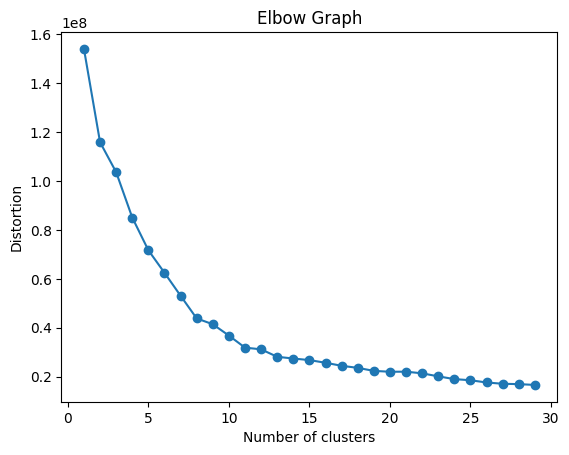

In [12]:
# plot the data
plt.plot(range(1, 30), distortions, marker='o')
plt.title("Elbow Graph")
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [13]:
km = KMeans(n_clusters=11,
            n_init='auto',
            random_state=0)
clusters = km.fit_predict(Xtrain)

In [14]:
df_NB['clusters'] = clusters

In [15]:
df_NB

Filename  \
0     .\SpamAssassinMessages\easy_ham\00001.7c53336b...   
1     .\SpamAssassinMessages\easy_ham\00002.9c4069e2...   
2     .\SpamAssassinMessages\easy_ham\00003.860e3c3c...   
3     .\SpamAssassinMessages\easy_ham\00004.864220c5...   
4     .\SpamAssassinMessages\easy_ham\00005.bf27cdea...   
...                                                 ...   
9348  .\SpamAssassinMessages\spam_2\01397.f75f0dd0dd...   
9349  .\SpamAssassinMessages\spam_2\01398.8ca7045aae...   
9350  .\SpamAssassinMessages\spam_2\01399.2319643317...   
9351  .\SpamAssassinMessages\spam_2\01400.b444b69845...   
9352                 .\SpamAssassinMessages\spam_2\cmds   

                      types  \
0                text/plain   
1                text/plain   
2                text/plain   
3                text/plain   
4                text/plain   
...                     ...   
9348  multipart/alternative   
9349             text/plain   
9350             text/plain   
9351             text/plain   
9352             text/plain   

                                             email_body labelnames  labels  \
0         Date:        Wed, 21 Aug 2002 10:54:46  05...        ham       1   
1     Martin A posted: Tassos Papadopoulos, the Gree...        ham       1   
2     Man Threatens Explosion In Moscow   Thursday A...        ham       1   
3     Klez: The Virus That Won't Die   Already the m...        ham       1   
4     >  in adding cream to spaghetti carbonara, whi...        ham       1   
...                                                 ...        ...     ...   
9348  Content Type: text/plain; \tcharset="Windows 1...       spam       0   
9349  Dear Subscriber,  If I could show you a way to...       spam       0   
9350  ****Mid Summer Customer Appreciation SALE!****...       spam       0   
9351  ATTN:SIR/MADAN                              ST...       spam       0   
9352  mv 00001.317e78fa8ee2f54cd4890fdc09ba8176 0000...       spam       0   

      clusters  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
9348         3  
9349         0  
9350         7  
9351         0  
9352         4  

[9353 rows x 6 columns]

In [66]:
df_NB[
    df_NB['types'] == 'multipart/signed'].email_body

14      Content Type: text/plain; charset=us ascii  > ...
119     Content Type: text/plain; charset=us ascii  > ...
196     Content Type: text/plain; charset=us ascii  > ...
328     Content Type: text/plain; charset=us ascii  > ...
423     Content Type: text/plain; charset=us ascii  > ...
                              ...                        
6336    Content Type: text/plain; charset=us ascii Con...
6357    Content Type: text/plain; charset=us ascii Con...
6360    Content Type: text/plain; charset=us ascii Con...
6653    Content Type: text/plain; \tcharset="iso 8859 ...
6869    Content Type: text/plain; \tcharset="iso 8859 ...
Name: email_body, Length: 180, dtype: object

In [16]:
type(Xtrain)

numpy.ndarray

In [17]:
Xtrain.shape

(9353, 125639)

In [18]:
New_Xtrain = np.hstack((Xtrain, clusters.reshape(-1, 1)))
New_Xtrain.shape

(9353, 125640)

In [19]:
cluster_array = np.array(df_NB['clusters'])
cluster_array.shape

(9353,)

### Naive Bayes Portion

##### Using Count Vectorizer

In [20]:
# Import Naive Bayes

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [21]:
training_data, testing_data = \
    train_test_split(df_NB, test_size=0.2, random_state=25)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 7482
No. of testing examples: 1871


In [22]:
the_count = CountVectorizer(ngram_range=(1, 2))

Xtrain = the_count.fit_transform(training_data['email_body'])

In [23]:
Xtrain = Xtrain.toarray()

In [24]:
# Fit Naive Bayes model
nb = MultinomialNB(alpha=0.1)
nb.fit(Xtrain, training_data['labels'])

MultinomialNB(alpha=0.1)

In [25]:
Xtest = the_count.transform(testing_data['email_body'])
preds = nb.predict(Xtest.toarray())

In [26]:
preds.shape

(1871,)

In [27]:
print(classification_report(testing_data['labels'], preds))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       480
           1       0.99      0.99      0.99      1391

    accuracy                           0.99      1871
   macro avg       0.99      0.98      0.99      1871
weighted avg       0.99      0.99      0.99      1871



In [28]:
# plot the confusion matrix

cnf_matrix = confusion_matrix(testing_data['labels'], preds)

print(cnf_matrix)

[[ 466   14]
 [   7 1384]]


##### Using TF-IDF Vectorizor

In [29]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))

Xtrain = tfidf.fit_transform(training_data['email_body'])

In [30]:
Xtrain = Xtrain.toarray()

In [31]:
# Fit Naive Bayes model
nb = MultinomialNB(alpha=0.1)
nb.fit(Xtrain, training_data['labels'])

MultinomialNB(alpha=0.1)

In [32]:
Xtest = tfidf.transform(testing_data['email_body'])
preds = nb.predict(Xtest.toarray())

In [33]:
preds.shape

(1871,)

In [34]:
print(classification_report(testing_data['labels'], preds))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       480
           1       0.98      1.00      0.99      1391

    accuracy                           0.98      1871
   macro avg       0.98      0.97      0.98      1871
weighted avg       0.98      0.98      0.98      1871



In [35]:
# plot the confusion matrix

cnf_matrix = confusion_matrix(testing_data['labels'], preds)

print(cnf_matrix)

[[ 451   29]
 [   6 1385]]


In [36]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': [0.1, 1, 10],
}

clf2 = GridSearchCV(text_clf, parameters, cv=5)
clf2.fit(training_data['email_body'], training_data['labels'])

print("Best parameters set found on development set:")
print(clf2.best_params_)

preds = clf2.predict(testing_data['email_body'])
print(classification_report(testing_data['labels'], preds))

cnf2_matrix = confusion_matrix(testing_data['labels'], preds)
print(cnf2_matrix)

Best parameters set found on development set:
{'clf__alpha': 0.1, 'vect__ngram_range': (1, 2)}
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       480
           1       0.99      0.99      0.99      1391

    accuracy                           0.99      1871
   macro avg       0.99      0.98      0.99      1871
weighted avg       0.99      0.99      0.99      1871

[[ 466   14]
 [   7 1384]]


In [55]:
text_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': [0.1, 1, 10],
}

clf2 = GridSearchCV(text_clf, parameters, cv=5)
clf2.fit(training_data['email_body'], training_data['labels'])

print("Best parameters set found on development set:")
print(clf2.best_params_)

preds = clf2.predict(testing_data['email_body'])
print(classification_report(testing_data['labels'], preds))

cnf2_matrix = confusion_matrix(testing_data['labels'], preds)
print(cnf2_matrix)

Best parameters set found on development set:
{'clf__alpha': 0.1, 'vect__ngram_range': (1, 2)}
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       480
           1       0.98      1.00      0.99      1391

    accuracy                           0.98      1871
   macro avg       0.98      0.97      0.98      1871
weighted avg       0.98      0.98      0.98      1871

[[ 451   29]
 [   6 1385]]


In [51]:
def prediction(df):
    count = CountVectorizer(ngram_range=(1, 2))
    clf = MultinomialNB(alpha=0.1)
    training_data, testing_data = \
        train_test_split(df, test_size=0.2, random_state=25)
    Xtrain = count.fit_transform(training_data['email_body'])
    Xtrain = Xtrain.toarray()
    cluster_array = np.array(training_data['clusters'])
    Xtrain2 = np.hstack((Xtrain, cluster_array.reshape(-1, 1)))
    clf.fit(Xtrain2, training_data['labels'])
    Xtest = count.transform(testing_data['email_body'])
    Xtest = Xtest.toarray()
    cluster_array = np.array(testing_data['clusters'])
    Xtest2 = np.hstack((Xtest, cluster_array.reshape(-1, 1)))
    preds = clf.predict(Xtest2)
    cnf2_matrix = confusion_matrix(testing_data['labels'], preds)
    return print(classification_report(testing_data['labels'], preds),
                 cnf2_matrix)

In [52]:
def create_df_from_file(path):
    file_name = []
    contents = []
    types = []
    labels = []
    labelnames = []
    message = ''
    for root, dirs, files in os.walk(path):
        for name in files:
            with open(os.path.join(root, name),
                      'r', encoding='latin1') as f:
                message = ''
                try:
                    x = email.message_from_file(f)
                except UnicodeDecodeError:
                    print("Error in file: Unknown Error")
                if "multipart" in x.get_content_type():
                    if x.is_multipart():
                        for part in x.get_payload():
                            message = message + part.as_string()
                    contents.append(message.replace("\n", " ")
                                    .replace(r'http\S+', ' ')
                                    .replace("-", " "))
                elif "text/plain" in x.get_content_type():
                    contents.append(x.get_payload()
                                    .replace("\n", " ")
                                    .replace(r'http\S+', ' ')
                                    .replace("-", " "))
                elif "text/html" in x.get_content_type():
                    contents.append(BS4(x.get_payload())
                                    .get_text()
                                    .replace(r'http\S+', ' ')
                                    .replace("\n", " ")
                                    .replace("-", " "))
                types.append(x.get_content_type())
                if "ham" in root:
                    labelnames.append('ham')
                    labels.append(1)
                elif "spam" in root:
                    labelnames.append('spam')
                    labels.append(0)
                file_name.append(os.path.join(root, name))
    df_NB = pd.DataFrame()
    df_NB['Filename'] = file_name
    df_NB['types'] = types
    df_NB['email_body'] = contents
    df_NB['labelnames'] = labelnames
    df_NB['labels'] = labels
    the_count = CountVectorizer()
    Xtrain = the_count.fit_transform(df_NB['email_body'])
    Xtrain = Xtrain.toarray()
    km = KMeans(n_clusters=11,
                n_init='auto',
                random_state=0)
    clusters = km.fit_predict(Xtrain)
    df_NB['clusters'] = clusters
    return df_NB

In [53]:
New_df = create_df_from_file(".\\SpamAssassinMessages")
New_df

Filename  \
0     .\SpamAssassinMessages\easy_ham\00001.7c53336b...   
1     .\SpamAssassinMessages\easy_ham\00002.9c4069e2...   
2     .\SpamAssassinMessages\easy_ham\00003.860e3c3c...   
3     .\SpamAssassinMessages\easy_ham\00004.864220c5...   
4     .\SpamAssassinMessages\easy_ham\00005.bf27cdea...   
...                                                 ...   
9348  .\SpamAssassinMessages\spam_2\01397.f75f0dd0dd...   
9349  .\SpamAssassinMessages\spam_2\01398.8ca7045aae...   
9350  .\SpamAssassinMessages\spam_2\01399.2319643317...   
9351  .\SpamAssassinMessages\spam_2\01400.b444b69845...   
9352                 .\SpamAssassinMessages\spam_2\cmds   

                      types  \
0                text/plain   
1                text/plain   
2                text/plain   
3                text/plain   
4                text/plain   
...                     ...   
9348  multipart/alternative   
9349             text/plain   
9350             text/plain   
9351             text/plain   
9352             text/plain   

                                             email_body labelnames  labels  \
0         Date:        Wed, 21 Aug 2002 10:54:46  05...        ham       1   
1     Martin A posted: Tassos Papadopoulos, the Gree...        ham       1   
2     Man Threatens Explosion In Moscow   Thursday A...        ham       1   
3     Klez: The Virus That Won't Die   Already the m...        ham       1   
4     >  in adding cream to spaghetti carbonara, whi...        ham       1   
...                                                 ...        ...     ...   
9348  Content Type: text/plain; \tcharset="Windows 1...       spam       0   
9349  Dear Subscriber,  If I could show you a way to...       spam       0   
9350  ****Mid Summer Customer Appreciation SALE!****...       spam       0   
9351  ATTN:SIR/MADAN                              ST...       spam       0   
9352  mv 00001.317e78fa8ee2f54cd4890fdc09ba8176 0000...       spam       0   

      clusters  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
9348         3  
9349         0  
9350         7  
9351         0  
9352         4  

[9353 rows x 6 columns]

In [54]:
prediction(New_df)

MemoryError: Unable to allocate 9.86 GiB for an array with shape (1871, 707420) and data type int64